<a href="https://colab.research.google.com/github/slayerzeroa/Option_Pricing_Practice/blob/main/Heston_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
import time

import copy

### Heston Model

In [23]:
# Simulation Setting
T = 1.0             # Time
N = 252             # The number of split
dt = T/N            # Delta time
sim = 1000          # The number of simulations

# Initial Value
S0 = 100.0          # Initial Stock Price
v0 = 0.25**2        # Initial Volatility

# Constants of Heston Process
ksi = 0.5           # Volatility of Volatility
kappa = 3           # Kappa; the rate at which νt reverts to θ.
theta = 0.2**2      # Theta;  the long variance, or long-run average variance of the price; as t tends to infinity, the expected value of νt tends to θ.
rho = -0.2          # Rho; the correlation of the two Wiener processes. (Returns <-> Volatility in this simulation)
mu = 0.02           # mu; Expected Returns

In [4]:
def heston_process(ksi, kappa, theta, rho, mu, return_vol=False, random_seed=21):
  '''
  ksi           # Ksi;   Volatility of Volatility
  kappa         # Kappa; The rate at which νt reverts to θ.
  theta         # Theta; The long variance, or long-run average variance of the price; as t tends to infinity, the expected value of νt tends to θ.
  rho           # Rho;   The correlation of the two Wiener processes. (Stock Price <-> Volatility in this simulation)
  mu            # Mu;    Expected Returns
  '''
  np.random.seed(random_seed)
  dt = T/N

  mean = np.array([0, 0])
  cov = np.array([[1,rho],
                  [rho, 1]])
  Z = np.random.multivariate_normal(mean, cov, (N, sim))

  S = np.zeros(shape=(N+1, sim))
  V = np.zeros(shape=(N+1, sim))

  S[0, :] = S0
  V[0, :] = v0

  for i in range(1, N+1):
    S[i] = S[i-1] * np.exp((mu-0.5*V[i-1])*dt+np.sqrt(V[i-1]*dt)*Z[i-1, :, 0])
    V[i] = np.maximum(V[i-1] + (kappa*(theta-V[i-1])*dt + ksi*np.sqrt(V[i-1] * dt)*Z[i-1, :, 1]), 0)

  if return_vol:
    return S, V

  return S

In [5]:
S, V = heston_process(ksi, kappa, theta, rho, mu, return_vol = True)

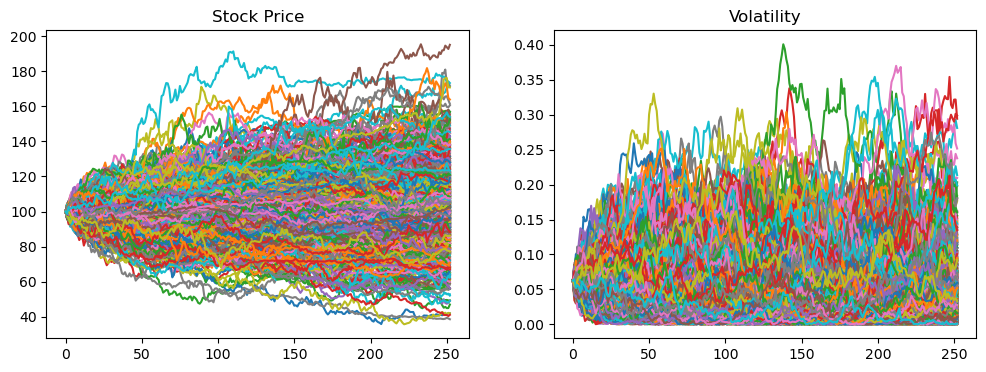

In [6]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(S)
axs[0].set_title("Stock Price")
axs[1].plot(V)
axs[1].set_title("Volatility")

plt.show()

In [7]:
rho_p = 0.8
rho_n = -0.8

price_p, vol_p = heston_process(ksi, kappa, theta, rho_p, mu, return_vol=True)
price_n, vol_n = heston_process(ksi, kappa, theta, rho_n, mu, return_vol=True)

### BSM 비교

In [8]:
# Simulation Setting
T = 1.0             # Maturity
N = 252             # Number of Time Steps
dt = T/N            # Delta time
sim = 1000          # The number of Simulations

# Initial Value
S0 = 100.0          # Inital Stock Price

# Constants of Geometry Brownian Motion
sigma = 0.25 ** 2   # Volatility of Returns
mu = 0.02           # Expected Returns

In [9]:
# for문 이용; 상대적 비효율성
def simulate_gbm(sigma, random_seed=21):
    np.random.seed(random_seed)
    Z = np.random.normal(size=(N, sim))
    sheet = np.zeros(shape=[N + 1, sim])
    for j in range(sim):
        sheet[0, j] = S0
        for i in range(1, N + 1):
            sheet[i, j] = sheet[i-1, j] * np.exp((mu - 0.5 * sigma ** 2)*dt + sigma*np.sqrt(dt) * Z[i-1, j])
    return sheet

start = time.time()
sheet = simulate_gbm(sigma)
print("time :", time.time() - start)

time : 0.42351746559143066


In [10]:
# 행렬 연산 이용; 상대적 효율성
def simulate_gbm(sigma, random_seed=42):
  np.random.seed(random_seed)
  Z = np.random.normal(size=(N, sim))
  sheet = np.zeros(shape=[N+1, sim])
  sheet[0, :] = S0
  for i in range(1, N+1):
    sheet[i] = sheet[i-1] * np.exp((mu - 0.5 * sigma ** 2)*dt + sigma*np.sqrt(dt) * Z[i-1, :])
  return sheet

start = time.time()
sheet = simulate_gbm(sigma)
print("time :", time.time() - start)

time : 0.008006095886230469


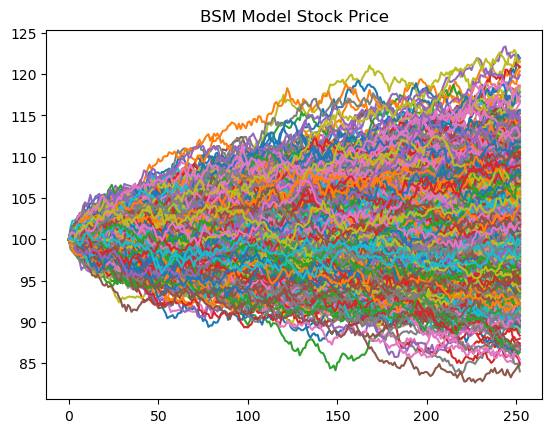

In [11]:
plt.plot(sheet)
plt.title("BSM Model Stock Price")
plt.show()

### Kernel Denstity Estimate

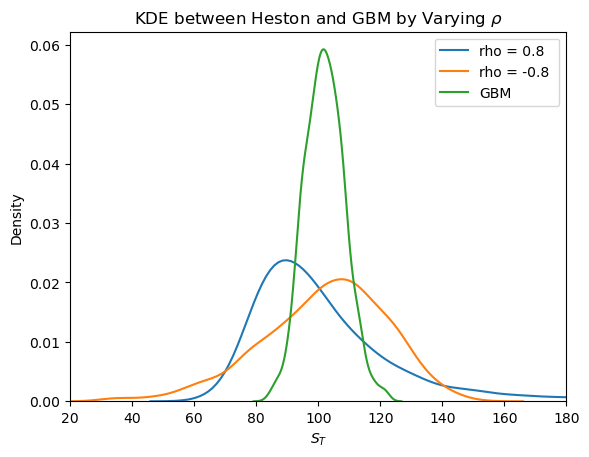

In [12]:
import seaborn as sns

fig, ax = plt.subplots()

ax = sns.kdeplot(data=price_p[-1], label=f"rho = {rho_p}", ax=ax)
ax = sns.kdeplot(data=price_n[-1], label=f"rho = {rho_n} ", ax=ax)
ax = sns.kdeplot(data=sheet[-1], label="GBM", ax=ax)

ax.set_title(r'KDE between Heston and GBM by Varying $\rho$')
plt.xlim([20, 180])
plt.xlabel('$S_T$')
plt.ylabel('Density')
plt.legend()
plt.show()

### Heston Model을 이용한 Option Pricing

In [27]:
# Parameter 설정

# Risk Free Rate
rf = 0.02
rf_daily = np.exp(rf/N) - 1


# Strike Price
# 콜옵션 기준
K = 110

In [36]:
# S[-1]에서 K를 뺀 값이 Call Option의 Payoff
call_p = np.maximum(S[-1] - K, 0)

# call_p가 0보다 작으면 0으로 만들어줌
call_p[call_p < 0] = 0

# Option의 현재 가치
call_option_price = np.mean(call_p) / ((1 + rf_daily)**N)
put_option_price = np.mean(np.maximum(K - S[-1], 0)) / ((1 + rf_daily)**N)

print(f"Call Option Price : {call_option_price}")
print(f"Put Option Price : {put_option_price}")


Call Option Price : 4.698709601173411
Put Option Price : 12.895387187775862


In [43]:
# Excel로 내보내기

export_S = copy.deepcopy(S)
export_S = pd.DataFrame(export_S)

export_S['option_price'] = None

export_S.loc[0, 'option_price'] = 'Call Option Price'
export_S.loc[1, 'option_price'] = call_option_price  
export_S.loc[2, 'option_price'] = 'Put Option Price'
export_S.loc[3, 'option_price'] = put_option_price

export_S.to_csv('export_S.csv', index=False)